# World Temperature

In [208]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from math import *
plt.rcParams["figure.figsize"] = (15, 8)

## Parseo de datos

In [196]:
df = pd.read_csv('data/worldTemperature.csv')

fechas = list(df['year'])
temps = list(df['temp'])

def cml(fns, xs, ys):
    A = np.array([fns(x) for x in xs], dtype=np.float64)
    ws = np.linalg.lstsq(A, ys)[0]
    return lambda x: sum([w*y for w, y in zip(ws, fns(x))])

def poly(grado):
    return lambda x: [float(x)**i for i in range(grado, -1, -1)]

def ecm(xs, ys):
    if len(xs) != len(ys): raise Exception('Different size!')
    return sum([(x - y)**2 for x, y in zip(xs, ys)])/len(xs)

#res = cml(lambda x: [x*2, x], [1,2,3], [1,1,1])
#res(5)

## f(x) = w1\*x + w2\*1

0.163376334191


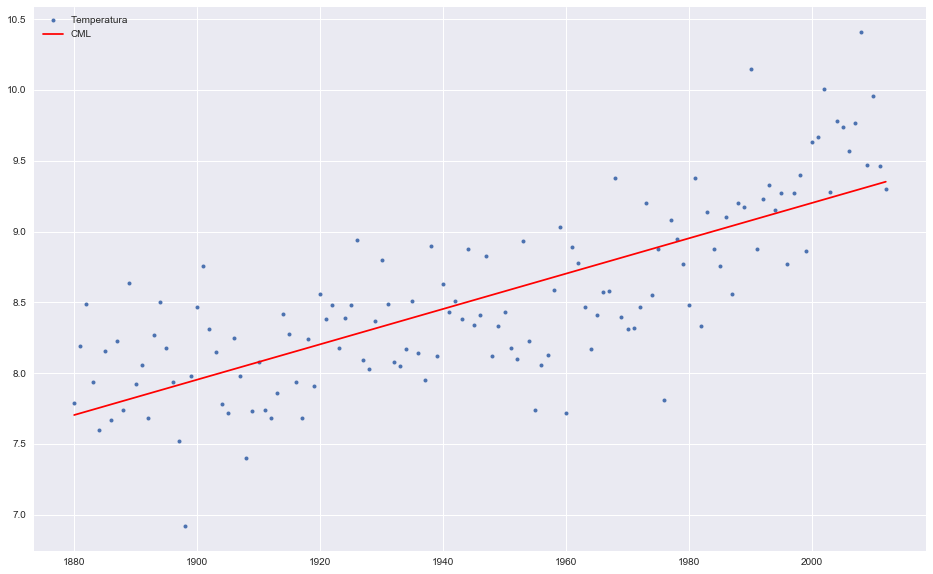

In [142]:
funcionCML = cml(lambda x: [x, 1], fechas, temps)
results = list(map(funcionCML, fechas))

plt.plot(fechas, temp, 'o', label='Temperatura', markersize=4)
plt.plot(fechas, results, 'r', label='CML')
plt.legend()
print(ecm(results, temps))
plt.show()

## f(x) = w1\*x^2 + w2\*x + w3\*1

0.135661729645


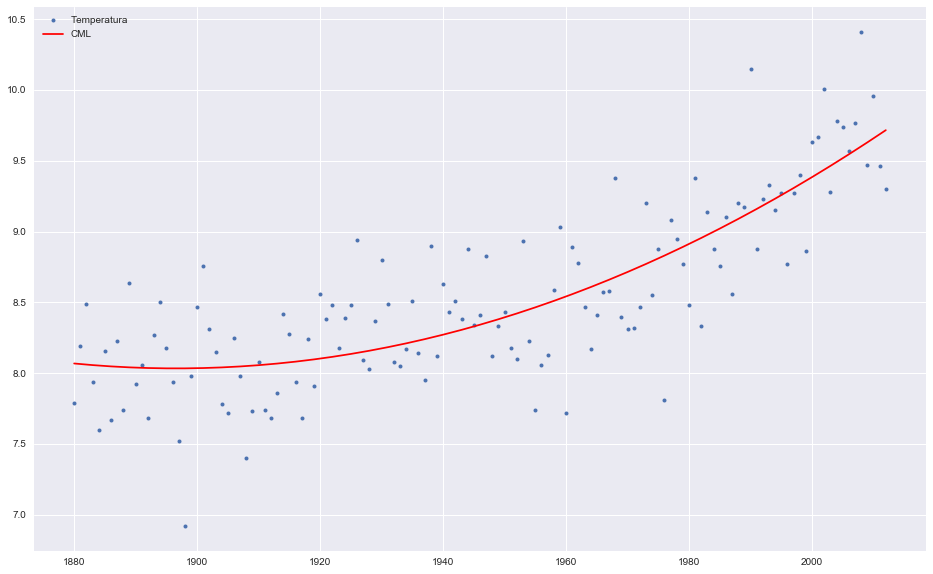

In [143]:
f = cml(lambda x: [x**2, x, 1], fechas, temps)
results = list(map(f, fechas))

plt.plot(fechas, temp, 'o', label='Temperatura', markersize=4)
plt.plot(fechas, results, 'r', label='CML')
plt.legend()
print(ecm(results, temps))
plt.show()

## f(x) con grado harcodeado

0.259969848479


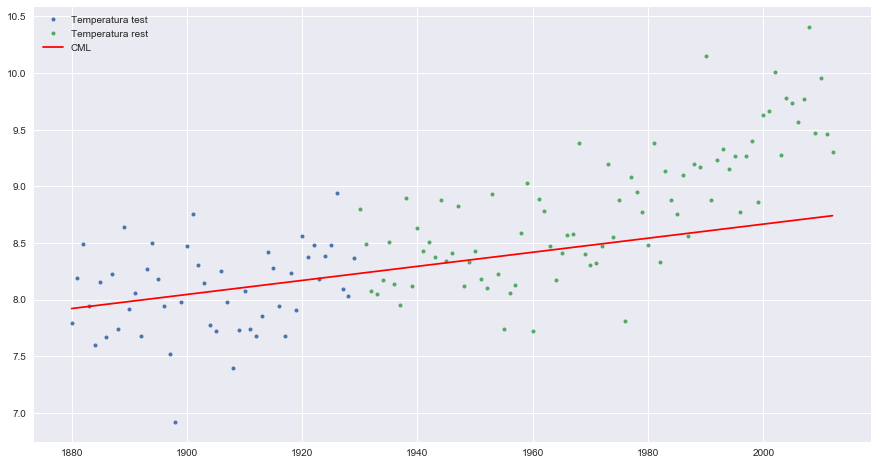

In [229]:
grados = range(0, 50, 1)
for g in grados:
n = 50
f = cml(poly(1), fechas[:n], temps[:n])
  
results = list(map(f, fechas))

plt.plot(fechas[:n], temps[:n], 'o', label='Temperatura test', markersize=4)
plt.plot(fechas[n:], temps[n:], 'o', label='Temperatura rest', markersize=4)
plt.plot(fechas, results, 'r', label='CML')
plt.legend()
print(ecm(results, temps))
plt.show()

(0.13231904018632787, 30)


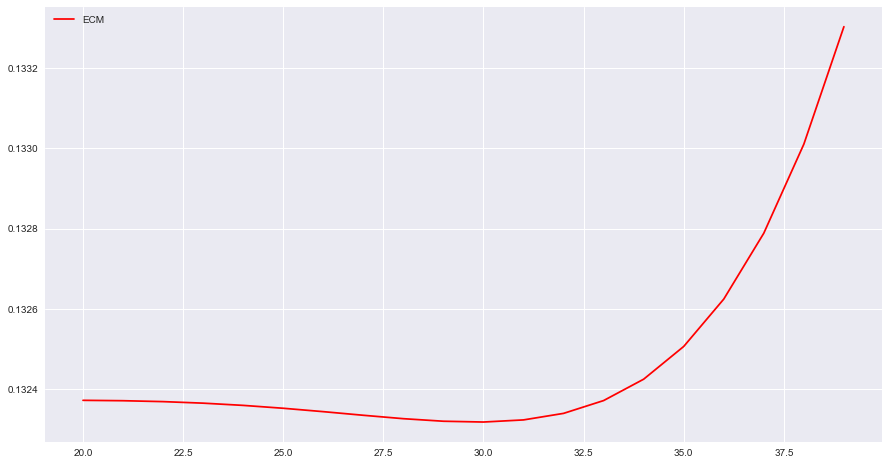

In [212]:
ecms = []

grados = range(20, 40, 1)
for grado in grados:
    f = cml(poly(grado), fechas, temps)
    results = list(map(f, fechas))
    ecms.append(ecm(results, temps))
    
m = min(zip(ecms, grados), key=lambda x: x[0])
print(m)

plt.plot(grados, ecms, 'r', label='ECM')
#plt.plot(fechas, results, 'r', label='CML')
plt.legend()
plt.show()